In [ ]:
import numpy as np
import pandas as pd
# import warnings
# warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt 

from IPython.display import HTML

import re
import string
import collections
import random
from math import ceil
from scipy.spatial.distance import cosine
from keras.utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\木木小呆猪\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# linear models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, SGDClassifier

# tree-based models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

# resemble models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# other models
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Data Preparation

In [3]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

def load_word2vec(filename):
    word2vec = {}
    with open(filename, encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

## data import

In [4]:
df_RAG = pd.read_csv("results/Appendix 1 - RAG result(all).csv")
word2vec = load_word2vec("results/Appendix 4 - word2vec_training.txt")

# 3 use the labels provided by RAG as our “ground truth” labels to train our classifier
references:

NLP_app_2024.ipynb

## 3.1 Split the data into training, validation, and testing

In [5]:
idx = df_RAG.index.values

# Since we need to segment the text later, we only separate the indexes of train, validation, and test here
# and then bring in specific values ​​after the subsequent processing
Train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=df_RAG['Predicted Investment Strategy'], random_state=42)
train_idx, val_idx = train_test_split(Train_idx, test_size=0.2, stratify=df_RAG.loc[Train_idx]['Predicted Investment Strategy'], random_state=42)

## 3.2 Use the skip-gram model to build a word embedding dictionary from the mutual fund prospectus in the training set.

In [6]:
def tokenizer(txt):
    stop_words = set(stopwords.words('english')+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [7]:
text_words = np.concatenate([tokenizer(summary) for summary in df_RAG['summaries']])

In [8]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [9]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3449


In [10]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [11]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [12]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [13]:
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

'''
attribute error for autoencoder.fit_generator()
AttributeError                            Traceback (most recent call last)
Cell In[45], line 2
      1 # Finally we can train the model by feeding it with our batch generator !
----> 2 autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)
AttributeError: 'Functional' object has no attribute 'fit_generator'

chatgpt told me to change the code into `autoencoder.fit()`
'''

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3449)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       172,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3449)           │       175,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,399 (1.33 MB)

 Trainable params: 348,399 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
7481/7481 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0534
Epoch 2/2
7481/7481 ━━━━━━━━━━━━━━━━━━━━ 120s 16ms/step - loss: 0.0021


"\nattribute error for autoencoder.fit_generator()\nAttributeError                            Traceback (most recent call last)\nCell In[45], line 2\n      1 # Finally we can train the model by feeding it with our batch generator !\n----> 2 autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)\nAttributeError: 'Functional' object has no attribute 'fit_generator'\n\nchatgpt told me to change the code into `autoencoder.fit()`\n"

In [14]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [15]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/

In [16]:
# We can save the word2vec dictionary to reuse it later.
our_word2vec = 'results/Appendix 4 - word2vec_training.txt'
def save_word2vec(filename):
    with open(filename,'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)
save_word2vec(our_word2vec)

## 3.3 Design a strategy to build knowledge bases associated to aforementioned three main mutual fund styles.

In [74]:
equity_keywords = ['stock','stocks', 'equity','equities', 'growth', 'capital', 'shares','long-term', 'investment', 'dividend', 'market', 'value']
fixed_income_keywords = ['bond', 'duration', 'yield', 'credit', 'interest','rate', 'fixed', 'income', 'debt', 'government', 'corporate','security','securities', 'high-yield', 'maturity', 'coupon', 'treasury', 'municipal', 'bonds']
balanced_keywords = ['allocation', 'diversified', 'equity', 'bond', 'mix', 'balanced']

In [75]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [76]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [77]:
#word2vec = load_word2vec(our_word2vec)
equity_knowledge_base = create_knowledge_base(5, word2vec, equity_keywords)
fixed_income_knowledge_base = create_knowledge_base(5, word2vec, fixed_income_keywords)
balanced_knowledge_base = create_knowledge_base(5, word2vec, balanced_keywords)

In [78]:
print('Equity Knowledge Base:') 
print(equity_knowledge_base)
print("5 closest words for each equity keyword:")
for key_word in equity_keywords:
    print(key_word + ' : ' + str(get_n_closer(key_word, 5, word2vec)))
print('Fixed Income Knowledge Base:')
print(fixed_income_knowledge_base)
print("5 closest words for each fixed income keyword:")
for key_word in fixed_income_keywords:
    print(key_word + ' : ' + str(get_n_closer(key_word, 5, word2vec)))
print('Balanced Knowledge Base:')
print(balanced_knowledge_base)
print("5 closest words for each balanced keyword:")
for key_word in balanced_keywords:
    print(key_word + ' : ' + str(get_n_closer(key_word, 5, word2vec)))

Equity Knowledge Base:
{'iv', 'global', 'issuer-specific', 'pronounced', 'purchase', 'value', 'regulatory', 'collectively', 'particularly', 'decline', 'investment', 'dividend', 'generally', 'achieve', 'diversification', 'advantages', 'market', 'buy', 'hold', '4th', 'international', 'strategies', 'stock', 'ting', 'gains', 'established', 'mid', 'stocks', 'conditions', 'dina', 'long-term', 'large', 'combination', 'managed', 'equities', 'unusual', 'non-u.s.', 'nonetheless', 'favor', 'underperforming', 'exempt', 'smet', 'capital', 'technology', 'adverse', 'sale', 'inc.', 'hedged', 'select', 'small', 'rhode', 'equity', 'records', 'shares', 'float-adjusted', 'growth', 'social', 'declining'}
5 closest words for each equity keyword:
stock : ['stock', 'decline', 'declining', 'unusual', 'pronounced']
stocks : ['stocks', 'particularly', 'non-u.s.', 'decline', 'issuer-specific']
equity : ['equity', 'international', 'global', 'hedged', 'small']
equities : ['equities', 'nonetheless', '4th', 'rhode', 

## 3.4.1 Measure distance of each summary to each knowledge base. 

In [79]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [80]:
df_RAG['equity_distance'] = df_RAG.apply(lambda x : extract_sentence_distance(x['summaries'], equity_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df_RAG['fixed_income_distance'] = df_RAG.apply(lambda x : extract_sentence_distance(x['summaries'], fixed_income_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df_RAG['balanced_distance'] = df_RAG.apply(lambda x : extract_sentence_distance(x['summaries'], balanced_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [81]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [82]:
df_RAG['equity_match'] = df_RAG.apply(lambda x : extract_sentence_match(x['summaries'], equity_knowledge_base, num_sent=5), axis=1)
df_RAG['fixed_income_match'] = df_RAG.apply(lambda x : extract_sentence_match(x['summaries'], fixed_income_knowledge_base, num_sent=5), axis=1)
df_RAG['balanced_match'] = df_RAG.apply(lambda x : extract_sentence_match(x['summaries'], balanced_knowledge_base, num_sent=5), axis=1)

In [83]:
df_RAG.to_csv("results/Appendix 5 - skip-gram match.csv", index=False)

## 3.4.2 Design a classification algorithm to predict the investment strategy of each fund. 

In [ ]:
X1 = df_RAG['equity_match'].values
X2 = df_RAG['fixed_income_match'].values
X3 = df_RAG['balanced_match'].values

X1 = [' '.join(tokenizer(txt)) for txt in X1]
X2 = [' '.join(tokenizer(txt)) for txt in X2]
X3 = [' '.join(tokenizer(txt)) for txt in X3]

X1 = pd.DataFrame(X1)
X2 = pd.DataFrame(X2)
X3 = pd.DataFrame(X3)

X1.rename(columns={0:'equity_match'}, inplace=True)
X2.rename(columns={0:'fixed_income_match'}, inplace=True)
X3.rename(columns={0:'balanced_match'}, inplace=True)
X = pd.concat([X1,X2,X3],axis =1)


In [150]:
X['match_all'] = X['equity_match'] + X['fixed_income_match'] + X['balanced_match']

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_26576\1070496877.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

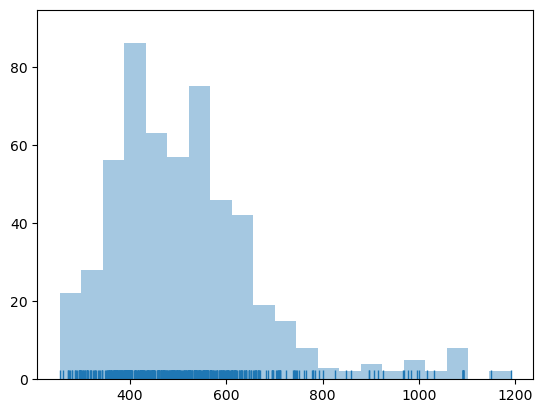

In [86]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X['match_all'].values) :
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

### Data preprocessing

In [87]:
# parameters
num_words = 2500 
maxlen = 150 
word_dimension = 50 

In [88]:
# train, validation set
y = df_RAG['Predicted Investment Strategy']

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_train_onehot = to_categorical(y_train, num_classes=4)
y_val_onehot = to_categorical(y_val, num_classes=4)

In [89]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train['match_all'])
word_index = keras_tokenizer.word_index

In [90]:
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
sequences_train_equity = keras_tokenizer.texts_to_sequences(X_train['equity_match'])
sequences_train_fixed_income = keras_tokenizer.texts_to_sequences(X_train['fixed_income_match'])
sequences_train_balanced = keras_tokenizer.texts_to_sequences(X_train['balanced_match'])

sequences_val_equity = keras_tokenizer.texts_to_sequences(X_val['equity_match'])
sequences_val_fixed_income = keras_tokenizer.texts_to_sequences(X_val['fixed_income_match'])
sequences_val_balanced = keras_tokenizer.texts_to_sequences(X_val['balanced_match'])

In [91]:
feature_train_equity = pad_sequences(sequences_train_equity, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_train_fixed_income = pad_sequences(sequences_train_fixed_income, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_train_balanced = pad_sequences(sequences_train_balanced, maxlen=maxlen, dtype=float, padding='post', truncating='post')

feature_val_equity = pad_sequences(sequences_val_equity, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val_fixed_income = pad_sequences(sequences_val_fixed_income, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val_balanced = pad_sequences(sequences_val_balanced, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [92]:
feature_train = np.concatenate([feature_train_equity, feature_train_fixed_income, feature_train_balanced], axis=1)
feature_val = np.concatenate([feature_val_equity, feature_val_fixed_income, feature_val_balanced], axis=1)

In [93]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Deep learning models

#### CNN

In [94]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units=4, activation='softmax'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [95]:
CNN_model = create_CNN_model()
CNN_history = CNN_model.fit(feature_train, y_train_onehot, epochs=10, batch_size=16, validation_data=(feature_val, y_val_onehot))

Epoch 1/10


d:\Program Files\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.3788 - loss: 0.6414 - val_accuracy: 0.4886 - val_loss: 0.4962
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4161 - loss: 0.5411 - val_accuracy: 0.4886 - val_loss: 0.4901
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4566 - loss: 0.5293 - val_accuracy: 0.4886 - val_loss: 0.4820
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4867 - loss: 0.5004 - val_accuracy: 0.4886 - val_loss: 0.4658
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5346 - loss: 0.4727 - val_accuracy: 0.4886 - val_loss: 0.4535
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5963 - loss: 0.4330 - val_accuracy: 0.5455 - val_loss: 0.4808
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5630 - loss: 0.4629 - val_accuracy: 0.5795 - val_loss: 0.4342
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6153 - loss: 0.4246 - val_accuracy: 0.5682 - val_loss: 0.

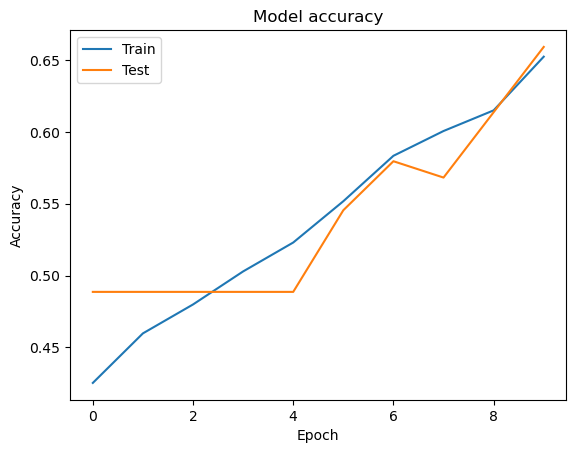

In [96]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

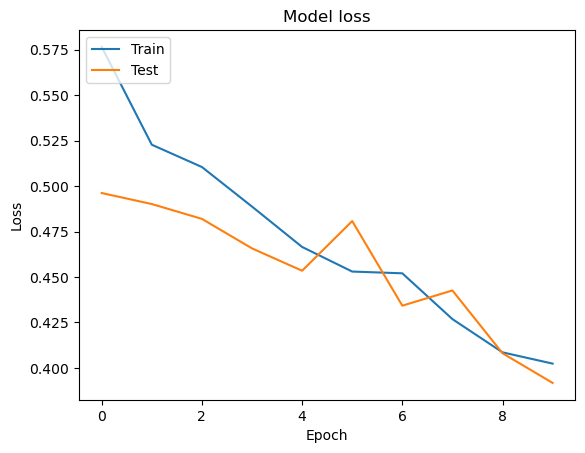

In [97]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### RNN

In [98]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='softmax'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [99]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, y_train_onehot, epochs=10, batch_size=16, validation_data=(feature_val, y_val_onehot))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.2513 - loss: 0.6130 - val_accuracy: 0.4886 - val_loss: 0.5036
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.4933 - loss: 0.4956 - val_accuracy: 0.4886 - val_loss: 0.4965
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.5121 - loss: 0.4856 - val_accuracy: 0.4886 - val_loss: 0.4918
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5198 - loss: 0.4691 - val_accuracy: 0.5000 - val_loss: 0.4896
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.5080 - loss: 0.4781 - val_accuracy: 0.5341 - val_loss: 0.4851
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.5372 - loss: 0.4627 - val_accuracy: 0.5455 - val_loss: 0.4902
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.5389 - loss: 0.4658 - val_accuracy: 0.5000 - val_loss: 0.4846
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.4860 - loss: 0.4704 - val_accuracy: 0

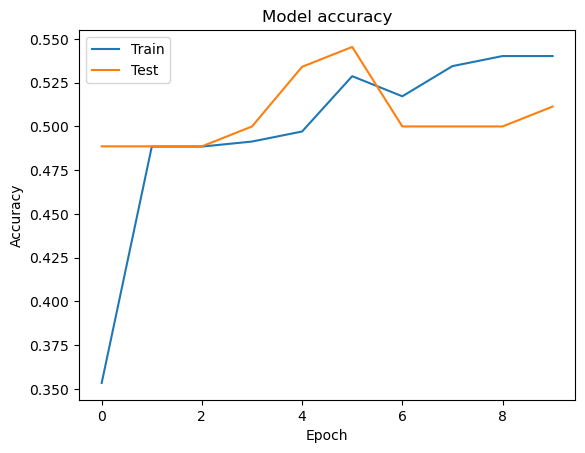

In [100]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

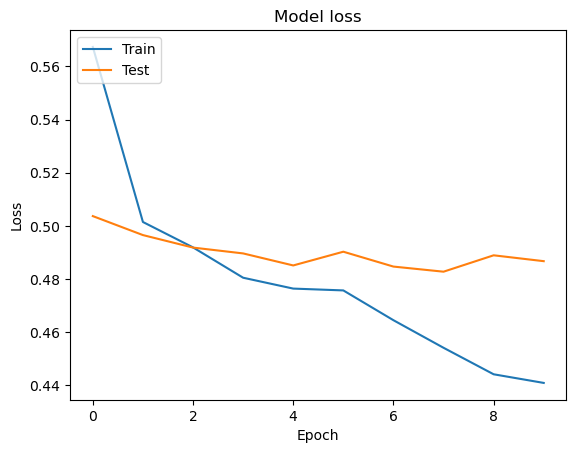

In [101]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Machine learning models

In [102]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    # "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "SGDClassifier": SGDClassifier(loss="log_loss", random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "BaggingClassifier": BaggingClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=100, random_state=42),
    "LGBMClassifier": LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42,verbose = -1),
    "CatBoostClassifier": CatBoostClassifier(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    "SVC": SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
}

In [103]:
ls_cm = []
ls_acc = []
ls_f1 = []
for name, model in models.items():
    model.fit(feature_train, y_train)
    y_pred = model.predict(feature_val)
    
    print(f"Model: {name}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred)
    print(cm)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')  

    print("Validation Accuracy:", acc)
    print("Validation F1 Score:", f1)

    print()

    ls_acc.append(acc)
    ls_f1.append(f1)
    ls_cm.append(cm)

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.60      0.74      0.67        43
           2       0.53      0.42      0.47        24
           3       0.67      0.62      0.64        13

    accuracy                           0.58        88
   macro avg       0.51      0.48      0.48        88
weighted avg       0.56      0.58      0.56        88

Confusion Matrix:
[[ 1  5  2  0]
 [ 3 32  7  1]
 [ 0 11 10  3]
 [ 0  5  0  8]]
Validation Accuracy: 0.5795454545454546
Validation F1 Score: 0.48461240310077514

Model: RidgeClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.63      0.63      0.63        43
           2       0.45      0.38      0.41        24
           3       0.50      0.62      0.55        13

    accuracy                         

d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: GradientBoostingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.61      0.91      0.73        43
           2       0.73      0.46      0.56        24
           3       0.88      0.54      0.67        13

    accuracy                           0.65        88
   macro avg       0.55      0.48      0.49        88
weighted avg       0.63      0.65      0.61        88

Confusion Matrix:
[[ 0  7  1  0]
 [ 0 39  3  1]
 [ 0 13 11  0]
 [ 1  5  0  7]]
Validation Accuracy: 0.6477272727272727
Validation F1 Score: 0.4899352983465133

Model: AdaBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.53      0.93      0.67        43
           2       0.60      0.25      0.35        24
           3       1.00      0.15      0.27        13

    accuracy               

d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: ExtraTreesClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.59      1.00      0.74        43
           2       1.00      0.33      0.50        24
           3       1.00      0.54      0.70        13

    accuracy                           0.66        88
   macro avg       0.65      0.47      0.49        88
weighted avg       0.71      0.66      0.60        88

Confusion Matrix:
[[ 0  8  0  0]
 [ 0 43  0  0]
 [ 0 16  8  0]
 [ 0  6  0  7]]
Validation Accuracy: 0.6590909090909091
Validation F1 Score: 0.4853448275862069



d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: BaggingClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.62      0.98      0.76        43
           2       0.77      0.42      0.54        24
           3       0.86      0.46      0.60        13

    accuracy                           0.66        88
   macro avg       0.56      0.46      0.47        88
weighted avg       0.64      0.66      0.61        88

Confusion Matrix:
[[ 0  5  2  1]
 [ 0 42  1  0]
 [ 0 14 10  0]
 [ 0  7  0  6]]
Validation Accuracy: 0.6590909090909091
Validation F1 Score: 0.47432432432432436



d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: XGBClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.68      0.88      0.77        43
           2       0.67      0.58      0.62        24
           3       0.60      0.46      0.52        13

    accuracy                           0.66        88
   macro avg       0.49      0.48      0.48        88
weighted avg       0.60      0.66      0.62        88

Confusion Matrix:
[[ 0  6  1  1]
 [ 0 38  5  0]
 [ 0  7 14  3]
 [ 1  5  1  6]]
Validation Accuracy: 0.6590909090909091
Validation F1 Score: 0.47790953008344317



d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

Model: LGBMClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.65      0.93      0.76        43
           2       0.72      0.54      0.62        24
           3       0.75      0.46      0.57        13

    accuracy                           0.67        88
   macro avg       0.53      0.48      0.49        88
weighted avg       0.62      0.67      0.63        88

Confusion Matrix:
[[ 0  6  1  1]
 [ 0 40  3  0]
 [ 0 10 13  1]
 [ 0  6  1  6]]
Validation Accuracy: 0.6704545454545454
Validation F1 Score: 0.4880952380952381

Model: CatBoostClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.59      0.98      0.74        43
           2       0.83      0.42      0.56        24
           3       1.00      0.38      0.56        13

    accuracy                           

d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: MLPClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.64      0.58      0.61        43
           2       0.43      0.50      0.46        24
           3       0.50      0.62      0.55        13

    accuracy                           0.52        88
   macro avg       0.44      0.46      0.44        88
weighted avg       0.52      0.52      0.52        88

Confusion Matrix:
[[ 1  3  2  2]
 [ 4 25 10  4]
 [ 0 10 12  2]
 [ 0  1  4  8]]
Validation Accuracy: 0.5227272727272727
Validation F1 Score: 0.4442162127191564

Model: SVC
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.58      1.00      0.74        43
           2       1.00      0.33      0.50        24
           3       0.67      0.31      0.42        13

    accuracy                           0.62        88
 

d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [104]:
df_results = pd.DataFrame({'Model': models.keys(), 'Accuracy': ls_acc, 'F1 Score': ls_f1, 'Confusion Matrix': ls_cm})
df_results

,Model,Accuracy,F1 Score,Confusion Matrix
0,LogisticRegression,0.579545,0.484612,"[[1, 5, 2, 0], [3, 32, 7, 1], [0, 11, 10, 3], ..."
1,RidgeClassifier,0.511364,0.426592,"[[1, 5, 0, 2], [5, 27, 10, 1], [2, 8, 9, 5], [..."
2,SGDClassifier,0.545455,0.417211,"[[0, 7, 1, 0], [3, 31, 7, 2], [0, 11, 10, 3], ..."
3,RandomForestClassifier,0.647727,0.466655,"[[0, 8, 0, 0], [0, 43, 0, 0], [0, 16, 8, 0], [..."
4,GradientBoostingClassifier,0.647727,0.489935,"[[0, 7, 1, 0], [0, 39, 3, 1], [0, 13, 11, 0], ..."
5,AdaBoostClassifier,0.545455,0.322969,"[[0, 7, 1, 0], [0, 40, 3, 0], [0, 18, 6, 0], [..."
6,ExtraTreesClassifier,0.659091,0.485345,"[[0, 8, 0, 0], [0, 43, 0, 0], [0, 16, 8, 0], [..."
7,BaggingClassifier,0.659091,0.474324,"[[0, 5, 2, 1], [0, 42, 1, 0], [0, 14, 10, 0], ..."
8,XGBClassifier,0.659091,0.477910,"[[0, 6, 1, 1], [0, 38, 5, 0], [0, 7, 14, 3], [..."
9,LGBMClassifier,0.670455,0.488095,"[[0, 6, 1, 1], [0, 40, 3, 0], [0, 10, 13, 1], ..."


In [198]:
df_results = pd.DataFrame({'Model': models.keys(), 'Accuracy': ls_acc, 'F1 Score': ls_f1, 'Confusion Matrix': ls_cm})
df_results.to_csv("results/Appendix 6 - basic machine model results.csv", index=False)

## 3.5 Use validation data to tune your parameters of your classification algorithms. 

In [209]:
param_grid = {
    'filters1': [64, 128],
    'filters2': [32, 64],
    'dense_units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32],
    'epochs': [10]
}

grid = list(ParameterGrid(param_grid))


In [210]:
def create_CNN_model1(params):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], 
                        input_length=maxlen, trainable=False))

    model.add(Convolution1D(params['filters1'], 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Convolution1D(params['filters2'], 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))

    model.add(Flatten())
    model.add(Dense(units=params['dense_units'], activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(units=4, activation='softmax'))

    model.compile(optimizer=params['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [211]:
results = []

for params in grid:
    model = create_CNN_model1(params)
    history = model.fit(feature_train, y_train_onehot,
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        validation_data=(feature_val, y_val_onehot),
                        verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    print(f"Params: {params}, Val Accuracy: {val_acc:.4f}")
    results.append((params, val_acc))

best = max(results, key=lambda x: x[1])
print("Best Parameters:", best[0])
print("Best Validation Accuracy:", best[1])

Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 64, 'filters2': 32, 'optimizer': 'adam'}, Val Accuracy: 0.6364
Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 64, 'filters2': 32, 'optimizer': 'rmsprop'}, Val Accuracy: 0.7159
Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 64, 'filters2': 64, 'optimizer': 'adam'}, Val Accuracy: 0.7273
Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 64, 'filters2': 64, 'optimizer': 'rmsprop'}, Val Accuracy: 0.6023
Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 128, 'filters2': 32, 'optimizer': 'adam'}, Val Accuracy: 0.6591
Params: {'batch_size': 32, 'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 10, 'filters1': 128, 'filters2': 32, 'optimizer': 'rmsprop'}, Val Accuracy: 0.6364
Params: {'batch_size': 32, 'dense_units': 64, 'dropou

In [212]:
best_model = create_CNN_model1(best[0])

best_model.fit(feature_train, y_train_onehot,
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        validation_data=(feature_val, y_val_onehot),
                        verbose=0)

y_pred_probs = best_model.predict(feature_val)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)  

f1_score(y_val, y_pred_classes, average='macro')

d:\Program Files\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


0.5672806243322339

### machine learning models

In [ ]:
lgb_param_grid = {
    'n_estimators': [100, 200, 300,500],
    'learning_rate': [0.001,0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
}

scores = []
params_ls = []
f1s = []
best_score = 0
best_params = None

for params in ParameterGrid(lgb_param_grid):
    model = LGBMClassifier(**params)
    model.fit(feature_train, y_train)
    y_pred = model.predict(feature_val)
    score = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    if score > best_score:
        best_score = score
        best_params = params

    scores.append(score)
    params_ls.append(params)
    f1s.append(f1)

df_lgb_search = pd.DataFrame()
df_lgb_search['accuracy'] = scores
df_lgb_search['f1_score'] = f1s
df_lgb_search['params'] = params_ls
df_lgb_search.sort_values(by='accuracy', ascending=False, inplace=True)
df_lgb_search

d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Pr

,accuracy,f1_score,params
54,0.704545,0.541554,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
53,0.704545,0.541554,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
63,0.693182,0.516056,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti..."
62,0.693182,0.516056,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti..."
46,0.693182,0.514260,"{'learning_rate': 0.05, 'max_depth': 9, 'n_est..."
...,...,...,...
1,0.500000,0.185385,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
8,0.488636,0.164122,"{'learning_rate': 0.001, 'max_depth': 7, 'n_es..."
4,0.488636,0.164122,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es..."
12,0.488636,0.164122,"{'learning_rate': 0.001, 'max_depth': 9, 'n_es..."


In [136]:
# 2. XGBoost Classifier Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300,500],
    'learning_rate': [0.001,0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
}

scores = []
params_ls = []
f1s = []
best_score = 0
best_params = None

for params in ParameterGrid(xgb_param_grid):
    model = XGBClassifier(**params)
    model.fit(feature_train, y_train)
    y_pred = model.predict(feature_val)
    score = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    if score > best_score:
        best_score = score
        best_params = params

    scores.append(score)
    params_ls.append(params)
    f1s.append(f1)

df_xgb_search = pd.DataFrame()
df_xgb_search['accuracy'] = scores
df_xgb_search['f1_score'] = f1s
df_xgb_search['params'] = params_ls
df_xgb_search.sort_values(by='accuracy', ascending=False, inplace=True)
df_xgb_search

,accuracy,f1_score,params
55,0.715909,0.544563,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
39,0.715909,0.541216,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
52,0.715909,0.544563,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
53,0.715909,0.544563,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
54,0.704545,0.535580,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
...,...,...,...
12,0.534091,0.403846,"{'learning_rate': 0.001, 'max_depth': 9, 'n_es..."
4,0.534091,0.419697,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es..."
2,0.534091,0.373831,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
8,0.522727,0.389116,"{'learning_rate': 0.001, 'max_depth': 7, 'n_es..."


In [183]:
# 3. Bagging Classifier Tuning

bagging_param_grid = {
    'n_estimators': [100, 200, 300,500],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False]
}

scores = []
params_ls = []
f1s = []
best_score = 0
best_params = None

for params in ParameterGrid(bagging_param_grid):
    model = BaggingClassifier(**params)
    model.fit(feature_train, y_train)
    y_pred = model.predict(feature_val)
    score = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    if score > best_score:
        best_score = score
        best_params = params

    scores.append(score)
    params_ls.append(params)
    f1s.append(f1)

df_bagging_search = pd.DataFrame()
df_bagging_search['accuracy'] = scores
df_bagging_search['f1_score'] = f1s
df_bagging_search['params'] = params_ls
df_bagging_search.sort_values(by='accuracy', ascending=False, inplace=True)
df_bagging_search

,accuracy,f1_score,params
4,0.681818,0.508123,"{'bootstrap': True, 'max_features': 0.5, 'max_..."
19,0.670455,0.489348,"{'bootstrap': True, 'max_features': 0.75, 'max..."
60,0.670455,0.489829,"{'bootstrap': False, 'max_features': 1.0, 'max..."
40,0.670455,0.487838,"{'bootstrap': False, 'max_features': 0.5, 'max..."
43,0.670455,0.483123,"{'bootstrap': False, 'max_features': 0.5, 'max..."
...,...,...,...
56,0.590909,0.446641,"{'bootstrap': False, 'max_features': 0.75, 'ma..."
71,0.590909,0.446481,"{'bootstrap': False, 'max_features': 1.0, 'max..."
68,0.579545,0.442935,"{'bootstrap': False, 'max_features': 1.0, 'max..."
69,0.579545,0.442935,"{'bootstrap': False, 'max_features': 1.0, 'max..."


## 3.6 Apply your classification algorithm to predict the investment strategy of each fund in the test data. Report your classification results in the test set.

### data preprocessing

In [165]:
# train, validation set
y = df_RAG['Predicted Investment Strategy']
X_Train, X_test = X.iloc[Train_idx], X.iloc[test_idx]
y_Train, y_test = y.iloc[Train_idx], y.iloc[test_idx]

y_Train_onehot = to_categorical(y_Train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

In [167]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer2 = Tokenizer(num_words=num_words)
keras_tokenizer2.fit_on_texts(X_Train['match_all'])
word_index2 = keras_tokenizer2.word_index

In [168]:
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
sequences_Train_equity = keras_tokenizer2.texts_to_sequences(X_Train['equity_match'])
sequences_Train_fixed_income = keras_tokenizer2.texts_to_sequences(X_Train['fixed_income_match'])
sequences_Train_balanced = keras_tokenizer2.texts_to_sequences(X_Train['balanced_match'])

sequences_test_equity = keras_tokenizer2.texts_to_sequences(X_test['equity_match'])
sequences_test_fixed_income = keras_tokenizer2.texts_to_sequences(X_test['fixed_income_match'])
sequences_test_balanced = keras_tokenizer2.texts_to_sequences(X_test['balanced_match'])

In [170]:
feature_Train_equity = pad_sequences(sequences_Train_equity, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_Train_fixed_income = pad_sequences(sequences_Train_fixed_income, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_Train_balanced = pad_sequences(sequences_Train_balanced, maxlen=maxlen, dtype=float, padding='post', truncating='post')

feature_test_equity = pad_sequences(sequences_test_equity, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test_fixed_income = pad_sequences(sequences_test_fixed_income, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test_balanced = pad_sequences(sequences_test_balanced, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [171]:
feature_Train = np.concatenate([feature_Train_equity, feature_Train_fixed_income, feature_Train_balanced], axis=1)
feature_test = np.concatenate([feature_test_equity, feature_test_fixed_income, feature_test_balanced], axis=1)

In [172]:
embedding_matrix2 = np.zeros((len(word_index2) + 1, word_dimension))
for word, i in word_index2.items():
    embedding_vector2 = word2vec.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector2 is not None:
        embedding_matrix2[i] = embedding_vector2

### models

In [207]:
best_model = create_CNN_model1(best[0])

best_model.fit(feature_Train, y_Train_onehot,
               batch_size=best[0]['batch_size'],
               epochs=best[0]['epochs'],
               verbose=0)

y_pred_probs = best_model.predict(feature_test)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)  

CNN_acc = accuracy_score(y_test, y_pred_classes)
CNN_f1 = f1_score(y_test, y_pred_classes, average='macro')
CNN_cm = confusion_matrix(y_test, y_pred_classes)
print("CNN Accuracy:", CNN_acc)
print("CNN F1 Score:", CNN_f1)
print("CNN Confusion Matrix:")
print(CNN_cm)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_classes))

d:\Program Files\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
CNN Accuracy: 0.6238532110091743
CNN F1 Score: 0.4927971188475391
CNN Confusion Matrix:
[[ 0  3  6  0]
 [ 0 34 16  3]
 [ 0  6 22  2]
 [ 0  2  3 12]]
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.76      0.64      0.69        53
           2       0.47      0.73      0.57        30
           3       0.71      0.71      0.71        17

    accuracy                           0.62       109
   macro avg       0.48      0.52      0.49       109
weighted avg       0.61      0.62      0.60       109



d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [195]:
lgbm_model = LGBMClassifier(learning_rate = df_lgb_search['params'][0]['learning_rate'],
                            n_estimators = df_lgb_search['params'][0]['n_estimators'], 
                            max_depth = df_lgb_search['params'][0]['max_depth'], 
                            random_state=42)
lgbm_model.fit(feature_Train, y_Train)
y_pred = lgbm_model.predict(feature_test)
lgm_acc = accuracy_score(y_test, y_pred)
lgm_f1 = f1_score(y_test, y_pred, average='macro')
lgbm_cm = confusion_matrix(y_test, y_pred)
print("LGBMClassifier Accuracy:", lgm_acc)
print("LGBMClassifier F1 Score:", lgm_f1)
print("LGBMClassifier Confusion Matrix:")   
print(lgbm_cm)
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred))

d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier Accuracy: 0.48623853211009177
LGBMClassifier F1 Score: 0.16358024691358025
LGBMClassifier Confusion Matrix:
[[ 0  9  0  0]
 [ 0 53  0  0]
 [ 0 30  0  0]
 [ 0 17  0  0]]
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.49      1.00      0.65        53
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        17

    accuracy                           0.49       109
   macro avg       0.12      0.25      0.16       109
weighted avg       0.24      0.49      0.32       109



d:\Program Files\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

In [196]:
xgb_model = XGBClassifier(learning_rate = df_xgb_search['params'][0]['learning_rate'],
                          n_estimators = df_xgb_search['params'][0]['n_estimators'], 
                          max_depth = df_xgb_search['params'][0]['max_depth'], 
                          random_state=42)
xgb_model.fit(feature_Train, y_Train)
y_pred = xgb_model.predict(feature_test)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_cm = confusion_matrix(y_test, y_pred)
print("XGBoost Classifier Accuracy:", xgb_acc)
print("XGBoost Classifier F1 Score:", xgb_f1)
print("XGBoost Classifier Confusion Matrix:")
print(xgb_cm)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Classifier Accuracy: 0.5596330275229358
XGBoost Classifier F1 Score: 0.41570247933884297
XGBoost Classifier Confusion Matrix:
[[ 0  8  1  0]
 [ 0 39 10  4]
 [ 0 14 13  3]
 [ 0  7  1  9]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.57      0.74      0.64        53
           2       0.52      0.43      0.47        30
           3       0.56      0.53      0.55        17

    accuracy                           0.56       109
   macro avg       0.41      0.42      0.42       109
weighted avg       0.51      0.56      0.53       109



d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [197]:
bagging_model = BaggingClassifier(n_estimators = df_bagging_search['params'][0]['n_estimators'],
                                  max_samples = df_bagging_search['params'][0]['max_samples'],
                                  max_features = df_bagging_search['params'][0]['max_features'],
                                  bootstrap = df_bagging_search['params'][0]['bootstrap'],
                                  random_state=42)
bagging_model.fit(feature_Train, y_Train)
y_pred = bagging_model.predict(feature_test)
bagging_acc = accuracy_score(y_test, y_pred)
bagging_f1 = f1_score(y_test, y_pred, average='macro')
bagging_cm = confusion_matrix(y_test, y_pred)
print("Bagging Classifier Accuracy:", bagging_acc)
print("Bagging Classifier F1 Score:", bagging_f1)
print("Bagging Classifier Confusion Matrix:")
print(bagging_cm)
print("Bagging Classifier Classification Report:")
print(classification_report(y_test, y_pred))

Bagging Classifier Accuracy: 0.6422018348623854
Bagging Classifier F1 Score: 0.4523230730127282
Bagging Classifier Confusion Matrix:
[[ 0  9  0  0]
 [ 0 53  0  0]
 [ 0 21  7  2]
 [ 0  7  0 10]]
Bagging Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.59      1.00      0.74        53
           2       1.00      0.23      0.38        30
           3       0.83      0.59      0.69        17

    accuracy                           0.64       109
   macro avg       0.61      0.46      0.45       109
weighted avg       0.69      0.64      0.57       109



d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
